# Using ST-Resnet for prediction of traffic

Here we fuse the weather and holidays along with the traffic flow in order to predict the traffic flow in the future


In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
"""The Data is taken from the following repository"""
!git clone https://github.com/liulingbo918/ATFM.git

Cloning into 'ATFM'...
remote: Enumerating objects: 83, done.
remote: Total 83 (delta 0), reused 0 (delta 0), pack-reused 83
Unpacking objects: 100% (83/83), 20.94 MiB | 7.24 MiB/s, done.


In [3]:
"""The data consists of 3 components: in/outflow and Holidays and weather data"""
!ls ./ATFM/data/TaxiNYC/

Holiday.txt  Meteorology.h5  NYC2014.h5  README.md


In [4]:
import h5py

def read_h5(filename):
    data = {}
    with h5py.File(filename, "r") as f:
        # List all groups
        a_group_key = list(f.keys())
        # Get the data
        for key in a_group_key:
            data[key] = list(f[key])
    return data

In [5]:
"""read flow data"""
flow_dir = "./ATFM/data/TaxiNYC/NYC2014.h5"
data = read_h5(flow_dir)
timeslot_data = np.array(data['date'])
flow_data = np.array(data['data'])

flow_data.shape, timeslot_data.shape

((17520, 2, 15, 5), (17520,))

In [6]:
"""read weather data"""
meteorology_data_dir = "./ATFM/data/TaxiNYC/Meteorology.h5"
meteorology_data = read_h5(meteorology_data_dir)
print(meteorology_data.keys())
temp_data = np.array(meteorology_data['Temperature']).reshape(17520, 1)
weather_data = np.array(meteorology_data['Weather'])
windspeed_data = np.array(meteorology_data['WindSpeed']).reshape(17520, 1)
date_data = np.array(meteorology_data['date']).reshape(17520, 1)
print(date_data.shape, weather_data.shape, windspeed_data.shape)

dict_keys(['Temperature', 'Weather', 'WindSpeed', 'date'])
(17520, 1) (17520, 17) (17520, 1)


In [7]:
import time
pbar = tqdm(total=100)
for i in range(10):
    time.sleep(0.1)
    pbar.update(10)
pbar.close()


100%|██████████| 100/100 [00:01<00:00, 98.45it/s]


In [8]:
"""Modified after: https://github.com/Mouradost/ASTIR"""

def load_holiday(timeslots):
    fname='./ATFM/data/TaxiNYC/Holiday.txt'
    f = open(fname, 'r')
    holidays = f.readlines()
    holidays = set([h.strip() for h in holidays])
    H = np.zeros(len(timeslots))
    for i, slot in enumerate(timeslots):
        if slot[:8] in holidays:
            H[i] = 1
    return H[:, None]


def load_meteorol(timeslots):
    fname = "./ATFM/data/TaxiNYC/Meteorology.h5"
    data  = read_h5(fname)
    Timeslot = np.array(data['date'])
    WindSpeed = np.array(data['WindSpeed'])
    Weather = np.array(data['Weather'])
    Temperature = np.array(data['Temperature'])

    M = dict() 
    for i, slot in enumerate(Timeslot):
        M[slot] = i

    """make weather, windspeed and tempreature arrays
       based on the time slots"""
    WS = []  # WindSpeed
    WR = []  # Weather
    TE = []  # Temperature
    
    for slot in timeslots:
        predicted_id = M[slot]
        cur_id = predicted_id - 1
        WS.append(WindSpeed[cur_id])
        WR.append(Weather[cur_id])
        TE.append(Temperature[cur_id])

    WS = np.asarray(WS)
    WR = np.asarray(WR)
    TE = np.asarray(TE)

    #standardize
    WS = (WS - WS.min()) / (WS.max() - WS.min())
    TE = (TE - TE.min()) / (TE.max() - TE.min())
    merge_data = np.hstack([WR, WS[:, None], TE[:, None]])
    return merge_data


class STMatrix(object):
    def __init__(self, data, timestamps, T=48):
        super(STMatrix, self).__init__()
        
        self.data = data
        self.timestamps = timestamps
        self.T = T
        self.pd_timestamps = string2timestamp(timestamps, T=self.T)
        self.make_index()

    def make_index(self):
        self.get_index = dict()
        for i, ts in enumerate(self.pd_timestamps):
            self.get_index[ts] = i

    def check_complete(self):
        missing_timestamps = []
        offset = pd.DateOffset(minutes=24 * 60 // self.T)
        pd_timestamps = self.pd_timestamps
        i = 1
        while i < len(pd_timestamps):
            if pd_timestamps[i-1] + offset != pd_timestamps[i]:
                missing_timestamps.append("(%s -- %s)" % (pd_timestamps[i-1], pd_timestamps[i]))
            i += 1
        for v in missing_timestamps:
            print(v)
        assert len(missing_timestamps) == 0

    def get_matrix(self, timestamp):
        return self.data[self.get_index[timestamp]]

    def save(self, fname):
        pass

    def check_it(self, depends):
        for d in depends:
            if d not in self.get_index.keys():
                return False
        return True

    def create_dataset(self, len_closeness=3, len_trend=3, TrendInterval=7, len_period=3, PeriodInterval=1):
        offset_frame = pd.DateOffset(minutes=24 * 60 // self.T)
        XC = []
        XP = []
        XT = []
        Y = []
        timestamps_Y = []
        depends = [range(1, len_closeness+1),
                   [PeriodInterval * self.T * j for j in range(1, len_period+1)],
                   [TrendInterval * self.T * j for j in range(1, len_trend+1)]]
        i = max(self.T * TrendInterval * len_trend, self.T * PeriodInterval * len_period, len_closeness)

        
        progress_bar = tqdm(total = len(self.pd_timestamps)+1)
        
        while i < len(self.pd_timestamps):
            Flag = True
            for depend in depends:
                if Flag is False:
                    break
                Flag = self.check_it([self.pd_timestamps[i] - j * offset_frame for j in depend])

            if Flag is False:
                i += 1
                continue
            x_c = [self.get_matrix(self.pd_timestamps[i] - j * offset_frame) for j in depends[0]]
            x_p = [self.get_matrix(self.pd_timestamps[i] - j * offset_frame) for j in depends[1]]
            x_t = [self.get_matrix(self.pd_timestamps[i] - j * offset_frame) for j in depends[2]]
            y = self.get_matrix(self.pd_timestamps[i])
            if len_closeness > 0:
                XC.append(np.vstack(x_c))
            if len_period > 0:
                XP.append(np.vstack(x_p))
            if len_trend > 0:
                XT.append(np.vstack(x_t))
            Y.append(y)
            timestamps_Y.append(self.timestamps[i])
            i += 1
            progress_bar.update(1)
            
        XC = np.asarray(XC)
        XP = np.asarray(XP)
        XT = np.asarray(XT)
        Y = np.asarray(Y)
    
        XC = XC.reshape(XC.shape[0], int(XC.shape[1]/2), 2, XC.shape[2], XC.shape[3])
        XP = XP.reshape(XP.shape[0], int(XP.shape[1]/2), 2, XP.shape[2], XP.shape[3])
        XT = XT.reshape(XT.shape[0], int(XT.shape[1]/2), 2, XT.shape[2], XT.shape[3])
        Y = Y.reshape(Y.shape[0], 2, Y.shape[2], Y.shape[3])
        return XC, XP, XT, Y, timestamps_Y



def load_data(T=48, len_closeness=None, len_period=None, 
              len_trend=None, len_test=4032):
    
    # read fow data
    fname = "./ATFM/data/TaxiNYC/NYC2014.h5"
    data  = read_h5(fname)
    timestamps = np.array(data['date'])
    data = np.array(data['data'])
    

    # Min max standardize
    minimum = data.min()
    maximum = data.max()
    data = (data - minimum) / (maximum - minimum)
    
    
    XC, XP, XT = [], [], []
    Y = []
    st = STMatrix(data, timestamps, T)
    XC, XP, XT, Y, timestamps_Y = st.create_dataset(len_closeness=len_closeness, 
                                                    len_period=len_period, 
                                                    len_trend=len_trend)

    ext_feature = []
    
    # load holiday
    holiday_feature = load_holiday(timestamps_Y)
    ext_feature.append(holiday_feature)

    # load meteorol data
    meteorol_feature = load_meteorol(timestamps_Y)
    ext_feature.append(meteorol_feature)

    if len(ext_feature) > 0:
        ext_feature = np.hstack(ext_feature)
    else:
        ext_feature = np.asarray(ext_feature) 
    
    print('holiday feature:', holiday_feature.shape)
    print('meteorol feature: ', meteorol_feature.shape)
    print('ext feature: ', ext_feature.shape)

    XC_train = XC[:-1*len_test] 
    XP_train = XP[:-1*len_test]
    XT_train = XT[:-1*len_test]
    Y_train = Y[:-1*len_test]
    
    XC_test = XC[-1*len_test:]
    XP_test = XP[-1*len_test:]
    XT_test = XT[-1*len_test:]
    Y_test = Y[-1*len_test:]

    X_train = []
    X_test = []
    
    for X in [XC_train, XP_train, XT_train]:
        X_train.append(X)
    for X in [XC_test, XP_test, XT_test]:
        X_test.append(X)

    ext_feature_train, ext_feature_test = ext_feature[:-len_test], ext_feature[-len_test:]
    X_train.append(ext_feature_train)
    X_test.append(ext_feature_test)
    
    return X_train, Y_train, X_test, Y_test, minimum, maximum
        

def string2timestamp(strings, T=48):
    timestamps = []
    time_per_slot = 24.0 / T
    num_per_T = T // 24
    for t in strings:
        year, month, day, slot = int(t[:4]), int(t[4:6]), int(t[6:8]), int(t[8:])-1
        timestamps.append(pd.Timestamp(
            datetime(year, month, day, hour=int(slot * time_per_slot), 
                     minute=(slot % num_per_T) * int(60.0 * time_per_slot))))
    return timestamps

In [9]:
import time
import pandas as pd
from datetime import datetime

X_train, Y_train, X_test, Y_test, minimum, maximum = load_data(len_closeness=3, len_period=3, len_trend=3)

"""build validation data from train data"""
X_train = [X_train[0][:-960], X_train[1][:-960],X_train[2][:-960], X_train[3][:-960]]
Y_train = Y_train[:-960]
X_val = [X_train[0][-960:], X_train[1][-960:],X_train[2][-960:], X_train[3][-960:]]
Y_val = Y_train[-960:]

print('Train Data')
print('closeness: ', X_train[0].shape)
print('period: ', X_train[1].shape)
print('trend: ', X_train[2].shape) 
print('external: ',X_train[3].shape)
print('ext dim: ',X_train[3].shape[1])
print('labels: ',Y_train.shape)

print('Val Data')
print('closeness: ', X_val[0].shape)
print('period: ', X_val[1].shape)
print('trend: ', X_val[2].shape) 
print('external: ',X_val[3].shape)
print('ext dim: ',X_val[3].shape[1])
print('labels: ',Y_val.shape)

 94%|█████████▍| 16512/17521 [06:25<00:23, 42.82it/s]


holiday feature: (16512, 1)
meteorol feature:  (16512, 19)
ext feature:  (16512, 20)
Train Data
closeness:  (11520, 3, 2, 15, 5)
period:  (11520, 3, 2, 15, 5)
trend:  (11520, 3, 2, 15, 5)
external:  (11520, 20)
ext dim:  20
labels:  (11520, 2, 15, 5)
Val Data
closeness:  (960, 3, 2, 15, 5)
period:  (960, 3, 2, 15, 5)
trend:  (960, 3, 2, 15, 5)
external:  (960, 20)
ext dim:  20
labels:  (960, 2, 15, 5)


In [10]:
"""Build data loaders with batch size"""
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c_X_train = torch.Tensor(X_train[0]).to(device)
p_X_train = torch.Tensor(X_train[1]).to(device)
t_X_train = torch.Tensor(X_train[2]).to(device)
ex_X_train = torch.Tensor(X_train[3]).to(device)
c_X_val = torch.Tensor(X_val[0]).to(device)
p_X_val = torch.Tensor(X_val[1]).to(device)
t_X_val = torch.Tensor(X_val[2]).to(device)
ex_X_val = torch.Tensor(X_val[3]).to(device)
c_X_test = torch.Tensor(X_test[0]).to(device)
p_X_test = torch.Tensor(X_test[1]).to(device)
t_X_test = torch.Tensor(X_test[2]).to(device)
ex_X_test = torch.Tensor(X_test[3]).to(device)
Y_train = torch.Tensor(Y_train).to(device)
Y_val = torch.Tensor(Y_val).to(device)
Y_test = torch.Tensor(Y_test).to(device)

batch_size = 32
train_data = torch.utils.data.TensorDataset(c_X_train, p_X_train,t_X_train, ex_X_train , Y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size)
val_data = torch.utils.data.TensorDataset(c_X_val, p_X_val,t_X_val, ex_X_val , Y_val)
val_iter = torch.utils.data.DataLoader(val_data, batch_size)
test_data = torch.utils.data.TensorDataset(c_X_test, p_X_test, t_X_test, ex_X_test , Y_test)
test_iter = torch.utils.data.DataLoader(test_data, batch_size)

In [11]:
import torch.nn as nn
from collections import OrderedDict

def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                     stride=stride, padding=1, bias= True)

class _bn_relu_conv(nn.Module):
    def __init__(self, nb_filter, bn = False):
        super(_bn_relu_conv, self).__init__()
        self.has_bn = bn
        self.relu = torch.relu
        self.conv1 = conv3x3(nb_filter, nb_filter)

    def forward(self, x):
        x = self.relu(x)
        x = self.conv1(x)

        return x

class _residual_unit(nn.Module):
    def __init__(self, nb_filter, bn=False):
        super(_residual_unit, self).__init__()
        self.bn_relu_conv1 = _bn_relu_conv(nb_filter, bn)
        self.bn_relu_conv2 = _bn_relu_conv(nb_filter, bn)

    def forward(self, x):
        residual = x
        out = self.bn_relu_conv1(x)
        out = self.bn_relu_conv2(out)
        out += residual # residual connection
        return out

class ResUnits(nn.Module):
    def __init__(self, residual_unit, nb_filter, repetations=1):
        super(ResUnits, self).__init__()
        self.stacked_resunits = self.make_stack_resunits(residual_unit, nb_filter, repetations)

    def make_stack_resunits(self, residual_unit, nb_filter, repetations):
        layers = []
        for i in range(repetations):
            layers.append(residual_unit(nb_filter))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stacked_resunits(x)

        return x

class TrainableEltwiseLayer(nn.Module):
    def __init__(self, n, h, w):
        super(TrainableEltwiseLayer, self).__init__()
        self.weights = nn.Parameter(torch.randn(1, n, h, w),
                                    requires_grad = True)  # define the trainable parameter

    def forward(self, x):
        x = x * self.weights 
        # element-wise fusion
        return x

class stresnet(nn.Module):
    def __init__(self, c_conf=(3, 2, 15, 5), p_conf=(4, 2, 15, 5),
                 t_conf=(4, 2, 15, 5), external_dim=28, nb_residual_unit=3):

        super(stresnet, self).__init__()

        self.external_dim = external_dim
        self.nb_residual_unit = nb_residual_unit
        self.c_conf = c_conf
        self.p_conf = p_conf
        self.t_conf = t_conf

        self.nb_flow, self.map_height, self.map_width = t_conf[1], t_conf[2], t_conf[3]

        self.relu = torch.relu
        self.tanh = torch.tanh
        self.quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
        self.qr_nums = len(self.quantiles)

        if self.c_conf is not None:
            self.c_way = self.make_one_way(in_channels = self.c_conf[0] * self.nb_flow)

        # Branch p
        if self.p_conf is not None:
            self.p_way = self.make_one_way(in_channels = self.p_conf[0] * self.nb_flow)

        # Branch t
        if self.t_conf is not None:
            self.t_way = self.make_one_way(in_channels = self.t_conf[0] * self.nb_flow)

        # Operations of external component
        if self.external_dim != None and self.external_dim > 0:
            self.external_ops = nn.Sequential(OrderedDict([
            ('embd', nn.Linear(self.external_dim, 10, bias = True)),
                ('relu1', nn.ReLU()),
            ('fc', nn.Linear(10, self.nb_flow * self.map_height * self.map_width, bias = True)),
                ('relu2', nn.ReLU()),
            ]))

    def make_one_way(self, in_channels):

        return nn.Sequential(OrderedDict([
            ('conv1', conv3x3(in_channels = in_channels, out_channels = 64)),
            ('ResUnits', ResUnits(_residual_unit, nb_filter = 64, repetations = self.nb_residual_unit)),
            ('relu', nn.ReLU()),
            ('conv2', conv3x3(in_channels = 64, out_channels = 2)),
            ('FusionLayer', TrainableEltwiseLayer(n = self.nb_flow, h = self.map_height, w = self.map_width))
        ]))

    def forward(self, input_c, input_p, input_t, input_ext):
        # Three-way Convolution
        main_output = 0
        if self.c_conf is not None:
            input_c = input_c.view(-1, self.c_conf[0]*2, self.map_height, self.map_width)
            out_c = self.c_way(input_c)
            main_output += out_c
        if self.p_conf is not None:
            input_p = input_p.view(-1, self.p_conf[0]*2, self.map_height, self.map_width)
            out_p = self.p_way(input_p)
            main_output += out_p
        if self.t_conf is not None:
            input_t = input_t.view(-1, self.t_conf[0]*2, self.map_height, self.map_width)
            out_t = self.t_way(input_t)
            main_output += out_t

        if self.external_dim != None and self.external_dim > 0:
            external_output = self.external_ops(input_ext)
            external_output = self.relu(external_output)
            external_output = external_output.view(-1, self.nb_flow, self.map_height, self.map_width)
            main_output += external_output

        else:
            print('external_dim:', external_dim)


        main_output = self.tanh(main_output)

        return main_output

In [12]:
c_data_shape = (3, 2, 15, 5)
p_data_shape = (3, 2, 15, 5)
t_data_shape = (3, 2, 15, 5)
st_resnet = stresnet(c_data_shape, p_data_shape, t_data_shape, external_dim=20, nb_residual_unit=4)
st_resnet.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(st_resnet.parameters(), lr=0.001)

In [13]:
def validate(model):
    model.eval()
    losses = []
    with torch.no_grad():
        for X_c, X_p, X_t, X_ext, Y in val_iter:
            outputs = model(X_c, X_p, X_t, X_ext)
            loss = loss_fn(outputs.cpu(), Y.cpu())
            losses.append(loss)
    mean_loss = np.mean(losses)
    return mean_loss

In [14]:
NUM_EPOCHS = 30

for epoch in range(NUM_EPOCHS):
    print('Epoch: ', epoch+1)
    print('=========')
    losses = []
    
    for X_c, X_p, X_t, X_ext, Y in train_iter:
        outputs = st_resnet(X_c, X_p, X_t, X_ext)
        loss = loss_fn(outputs, Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    train_loss = np.mean(losses)
    print('Train Loss: ', train_loss)
    val_loss = validate(st_resnet) 
    print('Val Loss: ', val_loss)

Epoch:  1
Train Loss:  0.0017442019403663127
Val Loss:  0.00035933426
Epoch:  2
Train Loss:  0.000362993341594928
Val Loss:  0.00029336373
Epoch:  3
Train Loss:  0.0002778905390490157
Val Loss:  0.00026357465
Epoch:  4
Train Loss:  0.00024547753294730984
Val Loss:  0.00020125053
Epoch:  5
Train Loss:  0.00020860045862920945
Val Loss:  0.00018563127
Epoch:  6
Train Loss:  0.00018827441562178945
Val Loss:  0.00017515132
Epoch:  7
Train Loss:  0.0001738555606304241
Val Loss:  0.00017026487
Epoch:  8
Train Loss:  0.0001655072995870594
Val Loss:  0.00016568725
Epoch:  9
Train Loss:  0.00015872081278050447
Val Loss:  0.00015663347
Epoch:  10
Train Loss:  0.00015660217983774297
Val Loss:  0.00014979535
Epoch:  11
Train Loss:  0.0001497667450267828
Val Loss:  0.00015071509
Epoch:  12
Train Loss:  0.0001457087641938415
Val Loss:  0.000141128
Epoch:  13
Train Loss:  0.0001482434348771575
Val Loss:  0.00014253563
Epoch:  14
Train Loss:  0.00013919038008478109
Val Loss:  0.00013194402
Epoch:  15
T

In [15]:
st_resnet.eval()
y_preds = list()
y_true = list()
with torch.no_grad():
    for X_c, X_p, X_t, X_ext, y in test_iter:
        y = y.cpu().numpy().reshape(-1)
        y_pred = st_resnet(X_c, X_p, X_t, X_ext).view(len(y), -1).cpu().numpy().reshape(-1)
        y *= maximum
        y_pred *= maximum
        y_preds.extend(list(y_pred))
        y_true.extend(list(y))
        
y_preds = np.array(y_preds)
y_true = np.array(y_true)

In [16]:
"""Overall evaluation the predictions of the test data"""
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true +=  1
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('RMSE: ', np.sqrt(mean_squared_error(y_true, y_preds)))
print('MAE: ', mean_absolute_error(y_true, y_preds))
print('MAPE: ', mean_absolute_percentage_error(y_true, y_preds), "%")

RMSE:  21.98225
MAE:  12.668083
MAPE:  42.381516098976135 %


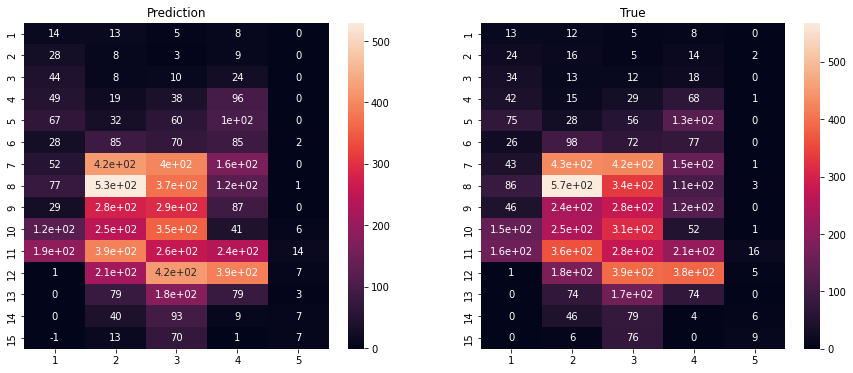

In [17]:
"""Prediction of inflow at certain time slice"""

import matplotlib.pyplot as plt
import seaborn as sns

one_time_slice_inflow_true = y_true.reshape(4032, 2, 15, 5)[0, 0, :, :]
one_time_slice_inflow_preds = y_preds.reshape(4032, 2, 15, 5)[0, 0, :, :]
one_time_slice_inflow_preds = one_time_slice_inflow_preds.astype(int)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

y_axis_labels = range(1,16)
x_axis_labels = range(1,6)

sns.heatmap(one_time_slice_inflow_preds, 
                 xticklabels=x_axis_labels, 
                 yticklabels=y_axis_labels, 
                 ax=ax1, annot=True)

sns.heatmap(one_time_slice_inflow_true, 
                 xticklabels=x_axis_labels, 
                 yticklabels=y_axis_labels, 
                 ax=ax2, annot=True)

ax2.set_title('True')
ax1.set_title('Prediction')
plt.show()

# References:

- https://github.com/Mouradost/ASTIR

- https://github.com/BruceBinBoxing/ST-ResNet-Pytorch

- Junbo Zhang, Yu Zheng, Dekang Qi, Deep Spatio-Temporal Residual Networks for Citywide Crowd Flows Prediction, 2017

- https://github.com/snehasinghania/STResNet